## Goal

Here we want to know the parameter range, including 

1. The distance between a pair of atoms
2. The maximum of Omega
3. The maximum of abs value of Delta
4. The slew rate of Omega, Delta, and phi

that the local simulator can give reasonable result. And we will investigate what to suggest to customers if they want to go out of the range. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField

from braket.devices import LocalSimulator
device = LocalSimulator("braket_ahs")

from pprint import pprint as pp

def get_counters_from_result(result):
    post_sequences = [list(measurement.post_sequence) for measurement in result.measurements]
    post_sequences = ["".join(['r' if site==0 else 'g' for site in post_sequence]) for post_sequence in post_sequences]

    counters = {}
    for post_sequence in post_sequences:
        if post_sequence in counters:
            counters[post_sequence] += 1
        else:
            counters[post_sequence] = 1
    return counters


In [2]:
num0 = 10 # number of data points for a_range
num1 = 10 # number of data points for Omega
num2 = 10 # number of data points for Delta
a_range = np.linspace(2.0, 8.0, num0) * 1e-6 # The range of atomic distance
Omega_range = np.linspace(1.0, 20.0, num1) * 1e6 # The range of Omega
Delta_range = np.linspace(0.0, 200.0, num2) * 1e6 # The range of Omega

t_max = 4e-6 # We fix the duration of the program
C6 = 5.42e-24 # The interaction coefficient
shots = 10_000 # We fix the number of shots
steps = 100 # For time steps
nsteps = 1000 # For scipy
epsilon = 0.01 # threshold for the discrepancy of local sim and theory result

def Rb(Omega, Delta):
    return (C6/np.sqrt(Omega**2 + Delta**2))**(1/6)

In [3]:
def compare(programs, steps = steps, shots = shots, nsteps=nsteps):


    results_sim = {}
    results_theory = {}
    diff = {}

    for key, program in programs.items():
        
        try:
            result = device.run(program, steps = steps, shots = shots, nsteps=nsteps).result()
        except:
            print(f"Error for {key}")
            continue
        
        print(f"Result got for {key}")
        result_sim_temp = get_counters_from_result(result)
        
        results_sim[key] = {'gg': 0, 'rg': 0, 'gr': 0, 'rr': 0}
        
        
        num_pairs = int(len(list(result_sim_temp.keys())[0])/2)
                
        for key2, val2 in result_sim_temp.items():
            for i in range(num_pairs):
                results_sim[key][key2[2*i:2*i+2]] += val2

        # Get the theory result
        R, Omega, Delta = key[0]*1e-6, key[1]*1e6, key[2]*1e6
        H = np.array([
            [0, Omega/2, Omega/2, 0], 
            [Omega/2, -Delta, 0, Omega/2], 
            [Omega/2, 0, -Delta, Omega/2], 
            [0, Omega/2, Omega/2, -2*Delta + C6/(R**6)]
        ])

        U = scipy.linalg.expm(-1j * t_max * H)

        gg_theory = round(np.abs(U[0][0])**2 * shots*num_pairs)
        gr_theory = round(np.abs(U[0][1])**2 * shots*num_pairs)
        rg_theory = round(np.abs(U[0][2])**2 * shots*num_pairs)        
        rr_theory = shots*num_pairs - gg_theory - gr_theory - rg_theory
        

        results_theory[key] = {
            'gg': gg_theory,
            'gr': gr_theory,
            'rg': gr_theory,
            'rr': rr_theory        
        }

        diff[key] = {}

        
        for state in ['gg', 'gr', 'rg', 'rr']:
            diff[key][state] = abs(results_theory[key][state]-results_sim[key][state])/(shots*num_pairs)
            
    return results_sim, results_theory, diff

def visualize_diff(diff, state="gg", a_range = a_range, Omega_range = Omega_range, Delta_range = Delta_range):
    data = {}
    num_digits = 2
    for a in a_range:
        a2 = np.round(a*1e6, num_digits)
        data[a2] = np.full((len(Omega_range), len(Delta_range)), None, dtype = float)

    for key, val in diff.items():
        a, Omega, Delta = key[0], key[1], key[2]
        a2 = np.round(a, num_digits)
        Omega_ind = np.absolute(Omega_range - Omega * 1e6).argmin()
        Delta_ind = np.absolute(Delta_range - Delta * 1e6).argmin()        
        data[a2][Omega_ind, Delta_ind] = val[state] * 100
        
#     return data

    cols = 4
    rows = int(np.ceil(len(a_range)/cols))
#     fig, axn = plt.subplots(rows, cols, sharex=True, sharey=True, figsize = (4*6*rows, 4), squeeze=False)
    fig, axn = plt.subplots(rows, cols, sharex=True, sharey=True, squeeze=False)
    #     print(axn[1,1])
    cbar_ax = fig.add_axes([0.9, 0.1, .03, 0.9])

    for ind_a, a in enumerate(a_range):
        row = int(np.floor(ind_a/4))
        col = ind_a - 4 * row
        a2 = np.round(a*1e6, num_digits)
        ax = axn[row, col]
        sns.heatmap(data[a2], 
                    ax=ax,
                    vmin=0, vmax=1,
                    cbar_ax=cbar_ax)
        ax.set_title(f"a={a2} (micrometers)", fontsize = 20)
        ax.set_xticks([0+0.5, len(Delta_range)-1+0.5])
        ax.set_yticks([0+0.5, len(Omega_range)-1+0.5])        
        ax.set_xlabel('Delta (MHz)', fontsize = 20)
        ax.set_ylabel('Omega (MHz)', fontsize = 20)     
        
        xticklabels = np.round(Delta_range[[0, len(Delta_range)-1]]/1e6, 2)
        yticklabels = np.round(Omega_range[[0, len(Omega_range)-1]]/1e6, 2)        
        ax.set_xticklabels(xticklabels, fontsize = 20)
        ax.set_yticklabels(yticklabels, fontsize = 20)

       
    fig.tight_layout(rect=[0, 0, .9, 1]) 

## Task 1: Const program for a pair of atoms
This is for testing the robustness of the numpy solver

In [4]:
programs = {}
for a in a_range:
    for Omega in Omega_range:
        for Delta in Delta_range:
            register = AtomArrangement()
            
            register.add([0, 0])
            register.add([a, 0.0])
            
            Omega_global = TimeSeries()
            Omega_global.put(0.0, Omega)
            Omega_global.put(t_max, Omega)

            # e.g. all-zero phase and detuning
            phi = TimeSeries().put(0.0, 0.0).put(t_max, 0.0)  # (time [s], value [rad])
            Delta_global = TimeSeries().put(0.0, Delta).put(t_max, Delta)  # (time [s], value [rad/s])

            drive = DrivingField(
                amplitude=Omega_global,
                phase=phi,
                detuning=Delta_global
            )            
            
            program = AnalogHamiltonianSimulation(
                hamiltonian=drive,
                register=register
            )
            
            programs[(a/1e-6, Omega/1e6, Delta/1e6)] = program
            

In [5]:
# programs

In [6]:
results_sim, results_theory, diff = compare(programs)

/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/atom_arrangement.py:108: UserWarning: Sites 0([Decimal('0'), Decimal('0')]) and site 1([Decimal('0.000002'), Decimal('0.0')]) are too close. Their Euclidean distance (0.000002 meters) is smaller than the typical scale (0.000004 meters). The coordinates of the sites should be specified in SI units.
  warnings.warn(


Result got for (2.0, 1.0, 0.0)
Result got for (2.0, 1.0, 22.22222222222222)
Result got for (2.0, 1.0, 44.44444444444444)
Result got for (2.0, 1.0, 66.66666666666666)
Result got for (2.0, 1.0, 88.88888888888889)
Result got for (2.0, 1.0, 111.11111111111111)


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 0 (133333333.33333331) in detuning time series outside the typical range [-125000000.0, 125000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for (2.0, 1.0, 133.33333333333331)
Result got for (2.0, 1.0, 155.55555555555554)


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 0 (155555555.55555555) in detuning time series outside the typical range [-125000000.0, 125000000.0]. The values should  be specified in SI units.
  warnings.warn(
/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 0 (177777777.77777776) in detuning time series outside the typical range [-125000000.0, 125000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for (2.0, 1.0, 177.77777777777777)


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 0 (200000000.0) in detuning time series outside the typical range [-125000000.0, 125000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for (2.0, 1.0, 200.0)
Result got for (2.0, 3.111111111111111, 0.0)
Result got for (2.0, 3.111111111111111, 22.22222222222222)
Result got for (2.0, 3.111111111111111, 44.44444444444444)
Result got for (2.0, 3.111111111111111, 66.66666666666666)
Result got for (2.0, 3.111111111111111, 88.88888888888889)
Result got for (2.0, 3.111111111111111, 111.11111111111111)
Result got for (2.0, 3.111111111111111, 133.33333333333331)
Result got for (2.0, 3.111111111111111, 155.55555555555554)
Result got for (2.0, 3.111111111111111, 177.77777777777777)
Result got for (2.0, 3.111111111111111, 200.0)
Result got for (2.0, 5.222222222222222, 0.0)
Result got for (2.0, 5.222222222222222, 22.22222222222222)
Result got for (2.0, 5.222222222222222, 44.44444444444444)
Result got for (2.0, 5.222222222222222, 66.66666666666666)
Result got for (2.0, 5.222222222222222, 88.88888888888889)
Result got for (2.0, 5.222222222222222, 111.11111111111111)
Result got for (2.0, 5.222222222222222, 133.33333333333331

/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/atom_arrangement.py:108: UserWarning: Sites 0([Decimal('0'), Decimal('0')]) and site 1([Decimal('0.0000026666666666666664'), Decimal('0.0')]) are too close. Their Euclidean distance (0.000002666666666666666400000000000 meters) is smaller than the typical scale (0.000004 meters). The coordinates of the sites should be specified in SI units.
  warnings.warn(


Result got for (2.6666666666666665, 1.0, 0.0)
Result got for (2.6666666666666665, 1.0, 22.22222222222222)
Result got for (2.6666666666666665, 1.0, 44.44444444444444)
Result got for (2.6666666666666665, 1.0, 66.66666666666666)
Result got for (2.6666666666666665, 1.0, 88.88888888888889)
Result got for (2.6666666666666665, 1.0, 111.11111111111111)
Result got for (2.6666666666666665, 1.0, 133.33333333333331)
Result got for (2.6666666666666665, 1.0, 155.55555555555554)
Result got for (2.6666666666666665, 1.0, 177.77777777777777)
Result got for (2.6666666666666665, 1.0, 200.0)
Result got for (2.6666666666666665, 3.111111111111111, 0.0)
Result got for (2.6666666666666665, 3.111111111111111, 22.22222222222222)
Result got for (2.6666666666666665, 3.111111111111111, 44.44444444444444)
Result got for (2.6666666666666665, 3.111111111111111, 66.66666666666666)
Result got for (2.6666666666666665, 3.111111111111111, 88.88888888888889)
Result got for (2.6666666666666665, 3.111111111111111, 111.1111111

/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/atom_arrangement.py:108: UserWarning: Sites 0([Decimal('0'), Decimal('0')]) and site 1([Decimal('0.000003333333333333333'), Decimal('0.0')]) are too close. Their Euclidean distance (0.000003333333333333333000000000000 meters) is smaller than the typical scale (0.000004 meters). The coordinates of the sites should be specified in SI units.
  warnings.warn(


Result got for (3.333333333333333, 1.0, 0.0)
Result got for (3.333333333333333, 1.0, 22.22222222222222)
Result got for (3.333333333333333, 1.0, 44.44444444444444)
Result got for (3.333333333333333, 1.0, 66.66666666666666)
Result got for (3.333333333333333, 1.0, 88.88888888888889)
Result got for (3.333333333333333, 1.0, 111.11111111111111)
Result got for (3.333333333333333, 1.0, 133.33333333333331)
Result got for (3.333333333333333, 1.0, 155.55555555555554)
Result got for (3.333333333333333, 1.0, 177.77777777777777)
Result got for (3.333333333333333, 1.0, 200.0)
Result got for (3.333333333333333, 3.111111111111111, 0.0)
Result got for (3.333333333333333, 3.111111111111111, 22.22222222222222)
Result got for (3.333333333333333, 3.111111111111111, 44.44444444444444)
Result got for (3.333333333333333, 3.111111111111111, 66.66666666666666)
Result got for (3.333333333333333, 3.111111111111111, 88.88888888888889)
Result got for (3.333333333333333, 3.111111111111111, 111.11111111111111)
Result 

Result got for (4.0, 5.222222222222222, 177.77777777777777)
Result got for (4.0, 5.222222222222222, 200.0)
Result got for (4.0, 7.333333333333334, 0.0)
Result got for (4.0, 7.333333333333334, 22.22222222222222)
Result got for (4.0, 7.333333333333334, 44.44444444444444)
Result got for (4.0, 7.333333333333334, 66.66666666666666)
Result got for (4.0, 7.333333333333334, 88.88888888888889)
Result got for (4.0, 7.333333333333334, 111.11111111111111)
Result got for (4.0, 7.333333333333334, 133.33333333333331)
Result got for (4.0, 7.333333333333334, 155.55555555555554)
Result got for (4.0, 7.333333333333334, 177.77777777777777)
Result got for (4.0, 7.333333333333334, 200.0)
Result got for (4.0, 9.444444444444445, 0.0)
Result got for (4.0, 9.444444444444445, 22.22222222222222)
Result got for (4.0, 9.444444444444445, 44.44444444444444)
Result got for (4.0, 9.444444444444445, 66.66666666666666)
Result got for (4.0, 9.444444444444445, 88.88888888888889)
Result got for (4.0, 9.444444444444445, 111.

Result got for (4.666666666666666, 13.666666666666668, 44.44444444444444)
Result got for (4.666666666666666, 13.666666666666668, 66.66666666666666)
Result got for (4.666666666666666, 13.666666666666668, 88.88888888888889)
Result got for (4.666666666666666, 13.666666666666668, 111.11111111111111)
Result got for (4.666666666666666, 13.666666666666668, 133.33333333333331)
Result got for (4.666666666666666, 13.666666666666668, 155.55555555555554)
Result got for (4.666666666666666, 13.666666666666668, 177.77777777777777)
Result got for (4.666666666666666, 13.666666666666668, 200.0)
Result got for (4.666666666666666, 15.777777777777779, 0.0)
Result got for (4.666666666666666, 15.777777777777779, 22.22222222222222)
Result got for (4.666666666666666, 15.777777777777779, 44.44444444444444)
Result got for (4.666666666666666, 15.777777777777779, 66.66666666666666)
Result got for (4.666666666666666, 15.777777777777779, 88.88888888888889)
Result got for (4.666666666666666, 15.777777777777779, 111.1

Result got for (5.333333333333333, 17.88888888888889, 22.22222222222222)
Result got for (5.333333333333333, 17.88888888888889, 44.44444444444444)
Result got for (5.333333333333333, 17.88888888888889, 66.66666666666666)
Result got for (5.333333333333333, 17.88888888888889, 88.88888888888889)
Result got for (5.333333333333333, 17.88888888888889, 111.11111111111111)
Result got for (5.333333333333333, 17.88888888888889, 133.33333333333331)
Result got for (5.333333333333333, 17.88888888888889, 155.55555555555554)
Result got for (5.333333333333333, 17.88888888888889, 177.77777777777777)
Result got for (5.333333333333333, 17.88888888888889, 200.0)
Result got for (5.333333333333333, 20.0, 0.0)
Result got for (5.333333333333333, 20.0, 22.22222222222222)
Result got for (5.333333333333333, 20.0, 44.44444444444444)
Result got for (5.333333333333333, 20.0, 66.66666666666666)
Result got for (5.333333333333333, 20.0, 88.88888888888889)
Result got for (5.333333333333333, 20.0, 111.11111111111111)
Resu

Result got for (6.666666666666666, 5.222222222222222, 88.88888888888889)
Result got for (6.666666666666666, 5.222222222222222, 111.11111111111111)
Result got for (6.666666666666666, 5.222222222222222, 133.33333333333331)
Result got for (6.666666666666666, 5.222222222222222, 155.55555555555554)
Result got for (6.666666666666666, 5.222222222222222, 177.77777777777777)
Result got for (6.666666666666666, 5.222222222222222, 200.0)
Result got for (6.666666666666666, 7.333333333333334, 0.0)
Result got for (6.666666666666666, 7.333333333333334, 22.22222222222222)
Result got for (6.666666666666666, 7.333333333333334, 44.44444444444444)
Result got for (6.666666666666666, 7.333333333333334, 66.66666666666666)
Result got for (6.666666666666666, 7.333333333333334, 88.88888888888889)
Result got for (6.666666666666666, 7.333333333333334, 111.11111111111111)
Result got for (6.666666666666666, 7.333333333333334, 133.33333333333331)
Result got for (6.666666666666666, 7.333333333333334, 155.5555555555555

Result got for (7.333333333333333, 9.444444444444445, 111.11111111111111)
Result got for (7.333333333333333, 9.444444444444445, 133.33333333333331)
Result got for (7.333333333333333, 9.444444444444445, 155.55555555555554)
Result got for (7.333333333333333, 9.444444444444445, 177.77777777777777)
Result got for (7.333333333333333, 9.444444444444445, 200.0)
Result got for (7.333333333333333, 11.555555555555555, 0.0)
Result got for (7.333333333333333, 11.555555555555555, 22.22222222222222)
Result got for (7.333333333333333, 11.555555555555555, 44.44444444444444)
Result got for (7.333333333333333, 11.555555555555555, 66.66666666666666)
Result got for (7.333333333333333, 11.555555555555555, 88.88888888888889)
Result got for (7.333333333333333, 11.555555555555555, 111.11111111111111)
Result got for (7.333333333333333, 11.555555555555555, 133.33333333333331)
Result got for (7.333333333333333, 11.555555555555555, 155.55555555555554)
Result got for (7.333333333333333, 11.555555555555555, 177.777

Result got for (8.0, 17.88888888888889, 0.0)
Result got for (8.0, 17.88888888888889, 22.22222222222222)
Result got for (8.0, 17.88888888888889, 44.44444444444444)
Result got for (8.0, 17.88888888888889, 66.66666666666666)
Result got for (8.0, 17.88888888888889, 88.88888888888889)
Result got for (8.0, 17.88888888888889, 111.11111111111111)
Result got for (8.0, 17.88888888888889, 133.33333333333331)
Result got for (8.0, 17.88888888888889, 155.55555555555554)
Result got for (8.0, 17.88888888888889, 177.77777777777777)
Result got for (8.0, 17.88888888888889, 200.0)
Result got for (8.0, 20.0, 0.0)
Result got for (8.0, 20.0, 22.22222222222222)
Result got for (8.0, 20.0, 44.44444444444444)
Result got for (8.0, 20.0, 66.66666666666666)
Result got for (8.0, 20.0, 88.88888888888889)
Result got for (8.0, 20.0, 111.11111111111111)
Result got for (8.0, 20.0, 133.33333333333331)
Result got for (8.0, 20.0, 155.55555555555554)
Result got for (8.0, 20.0, 177.77777777777777)
Result got for (8.0, 20.0, 2

In [7]:
# results_sim

In [8]:
# results_theory

In [9]:
diff

{(2.0, 1.0, 0.0): {'gg': 0.0013, 'gr': 0.0016, 'rg': 0.0004, 'rr': 0.0001},
 (2.0, 1.0, 22.22222222222222): {'gg': 0.0001,
  'gr': 0.0002,
  'rg': 0.0002,
  'rr': 0.0001},
 (2.0, 1.0, 44.44444444444444): {'gg': 0.0,
  'gr': 0.0003,
  'rg': 0.0002,
  'rr': 0.0001},
 (2.0, 1.0, 66.66666666666666): {'gg': 0.0003,
  'gr': 0.0001,
  'rg': 0.0002,
  'rr': 0.0},
 (2.0, 1.0, 88.88888888888889): {'gg': 0.0001,
  'gr': 0.0,
  'rg': 0.0001,
  'rr': 0.0},
 (2.0, 1.0, 111.11111111111111): {'gg': 0.0004,
  'gr': 0.0002,
  'rg': 0.0003,
  'rr': 0.0001},
 (2.0, 1.0, 133.33333333333331): {'gg': 0.0, 'gr': 0.0, 'rg': 0.0, 'rr': 0.0},
 (2.0, 1.0, 155.55555555555554): {'gg': 0.0, 'gr': 0.0, 'rg': 0.0, 'rr': 0.0},
 (2.0, 1.0, 177.77777777777777): {'gg': 0.0, 'gr': 0.0, 'rg': 0.0, 'rr': 0.0},
 (2.0, 1.0, 200.0): {'gg': 0.0, 'gr': 0.0, 'rg': 0.0, 'rr': 0.0},
 (2.0, 3.111111111111111, 0.0): {'gg': 0.0111,
  'gr': 0.0029,
  'rg': 0.0082,
  'rr': 0.0},
 (2.0, 3.111111111111111, 22.22222222222222): {'gg': 0.0015

In [10]:
for key, val in diff.items():
    if val['gg'] > epsilon:
        print(key, ", ", f"val['gg'] = {val['gg']}", ", ", f"Rb = {Rb(key[1] * 1e6, key[2] * 1e6) * 1e6}")

(2.0, 3.111111111111111, 0.0) ,  val['gg'] = 0.0111 ,  Rb = 10.969343272916598
(2.0, 9.444444444444445, 66.66666666666666) ,  val['gg'] = 0.0148 ,  Rb = 6.570966897748595
(2.0, 9.444444444444445, 88.88888888888889) ,  val['gg'] = 0.0126 ,  Rb = 6.267856221910202
(2.0, 11.555555555555555, 66.66666666666666) ,  val['gg'] = 0.0172 ,  Rb = 6.565640417856654
(2.0, 11.555555555555555, 88.88888888888889) ,  val['gg'] = 0.0196 ,  Rb = 6.264966901140632
(2.0, 11.555555555555555, 111.11111111111111) ,  val['gg'] = 0.021 ,  Rb = 6.039267832659027
(2.0, 13.666666666666668, 66.66666666666666) ,  val['gg'] = 0.0224 ,  Rb = 6.559316385349993
(2.0, 15.777777777777779, 66.66666666666666) ,  val['gg'] = 0.0362 ,  Rb = 6.552032610121354
(2.0, 15.777777777777779, 88.88888888888889) ,  val['gg'] = 0.0119 ,  Rb = 6.257525760947148
(2.0, 15.777777777777779, 111.11111111111111) ,  val['gg'] = 0.0237 ,  Rb = 6.034636749326048
(2.0, 17.88888888888889, 66.66666666666666) ,  val['gg'] = 0.0526 ,  Rb = 6.543831355

/var/folders/17/wqjdf0nn4dj11p1h8yrx44100000gr/T/ipykernel_67442/2040182355.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


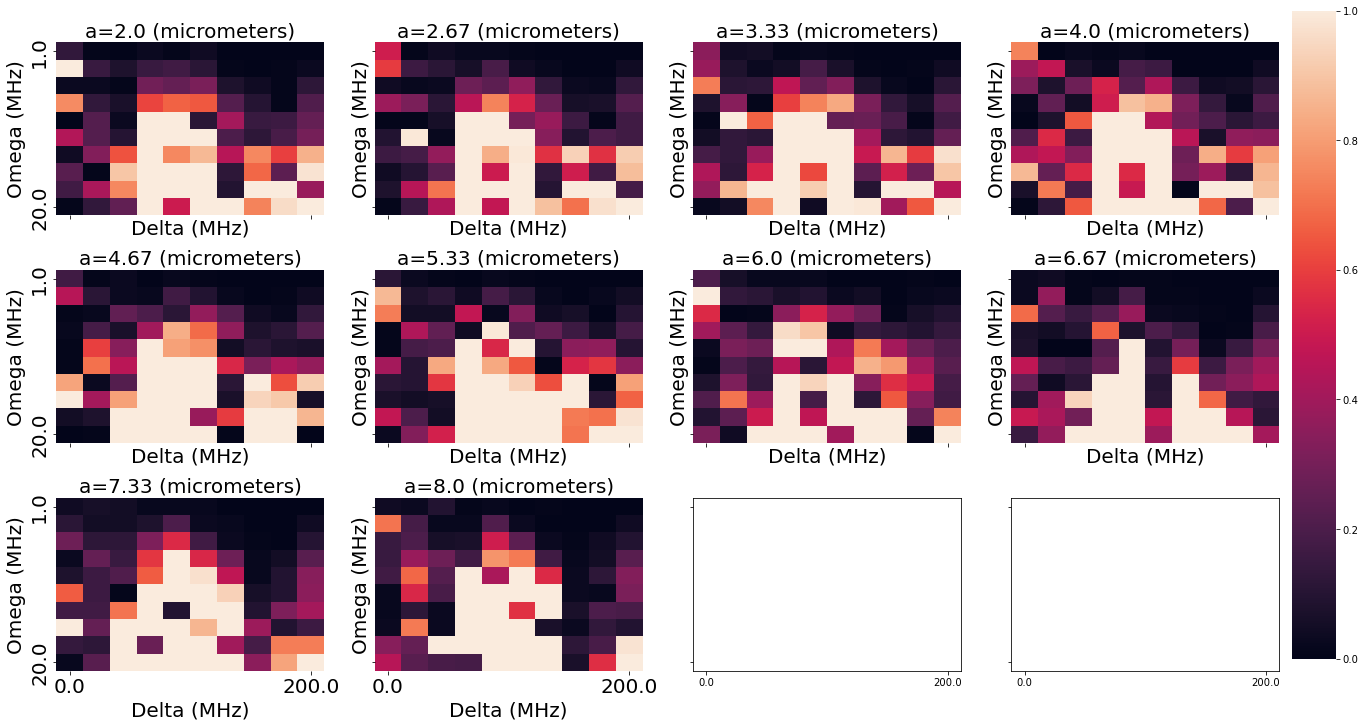

In [11]:
plt.rcParams["figure.figsize"] = (20,10)
visualize_diff(diff)

### Rerun with larger number of time steps

In [12]:
results_sim, results_theory, diff = compare(programs, shots = 100 * shots)

Result got for (2.0, 1.0, 0.0)
Result got for (2.0, 1.0, 22.22222222222222)
Result got for (2.0, 1.0, 44.44444444444444)
Result got for (2.0, 1.0, 66.66666666666666)
Result got for (2.0, 1.0, 88.88888888888889)
Result got for (2.0, 1.0, 111.11111111111111)
Result got for (2.0, 1.0, 133.33333333333331)
Result got for (2.0, 1.0, 155.55555555555554)
Result got for (2.0, 1.0, 177.77777777777777)
Result got for (2.0, 1.0, 200.0)
Result got for (2.0, 3.111111111111111, 0.0)
Result got for (2.0, 3.111111111111111, 22.22222222222222)
Result got for (2.0, 3.111111111111111, 44.44444444444444)
Result got for (2.0, 3.111111111111111, 66.66666666666666)
Result got for (2.0, 3.111111111111111, 88.88888888888889)
Result got for (2.0, 3.111111111111111, 111.11111111111111)
Result got for (2.0, 3.111111111111111, 133.33333333333331)
Result got for (2.0, 3.111111111111111, 155.55555555555554)
Result got for (2.0, 3.111111111111111, 177.77777777777777)
Result got for (2.0, 3.111111111111111, 200.0)
Resu

Result got for (2.6666666666666665, 9.444444444444445, 22.22222222222222)
Result got for (2.6666666666666665, 9.444444444444445, 44.44444444444444)
Result got for (2.6666666666666665, 9.444444444444445, 66.66666666666666)
Result got for (2.6666666666666665, 9.444444444444445, 88.88888888888889)
Result got for (2.6666666666666665, 9.444444444444445, 111.11111111111111)
Result got for (2.6666666666666665, 9.444444444444445, 133.33333333333331)
Result got for (2.6666666666666665, 9.444444444444445, 155.55555555555554)
Result got for (2.6666666666666665, 9.444444444444445, 177.77777777777777)
Result got for (2.6666666666666665, 9.444444444444445, 200.0)
Result got for (2.6666666666666665, 11.555555555555555, 0.0)
Result got for (2.6666666666666665, 11.555555555555555, 22.22222222222222)
Result got for (2.6666666666666665, 11.555555555555555, 44.44444444444444)
Result got for (2.6666666666666665, 11.555555555555555, 66.66666666666666)
Result got for (2.6666666666666665, 11.555555555555555, 

Result got for (3.333333333333333, 11.555555555555555, 200.0)
Result got for (3.333333333333333, 13.666666666666668, 0.0)
Result got for (3.333333333333333, 13.666666666666668, 22.22222222222222)
Result got for (3.333333333333333, 13.666666666666668, 44.44444444444444)
Result got for (3.333333333333333, 13.666666666666668, 66.66666666666666)
Result got for (3.333333333333333, 13.666666666666668, 88.88888888888889)
Result got for (3.333333333333333, 13.666666666666668, 111.11111111111111)
Result got for (3.333333333333333, 13.666666666666668, 133.33333333333331)
Result got for (3.333333333333333, 13.666666666666668, 155.55555555555554)
Result got for (3.333333333333333, 13.666666666666668, 177.77777777777777)
Result got for (3.333333333333333, 13.666666666666668, 200.0)
Result got for (3.333333333333333, 15.777777777777779, 0.0)
Result got for (3.333333333333333, 15.777777777777779, 22.22222222222222)
Result got for (3.333333333333333, 15.777777777777779, 44.44444444444444)
Result got f

Result got for (4.666666666666666, 1.0, 0.0)
Result got for (4.666666666666666, 1.0, 22.22222222222222)
Result got for (4.666666666666666, 1.0, 44.44444444444444)
Result got for (4.666666666666666, 1.0, 66.66666666666666)
Result got for (4.666666666666666, 1.0, 88.88888888888889)
Result got for (4.666666666666666, 1.0, 111.11111111111111)
Result got for (4.666666666666666, 1.0, 133.33333333333331)
Result got for (4.666666666666666, 1.0, 155.55555555555554)
Result got for (4.666666666666666, 1.0, 177.77777777777777)
Result got for (4.666666666666666, 1.0, 200.0)
Result got for (4.666666666666666, 3.111111111111111, 0.0)
Result got for (4.666666666666666, 3.111111111111111, 22.22222222222222)
Result got for (4.666666666666666, 3.111111111111111, 44.44444444444444)
Result got for (4.666666666666666, 3.111111111111111, 66.66666666666666)
Result got for (4.666666666666666, 3.111111111111111, 88.88888888888889)
Result got for (4.666666666666666, 3.111111111111111, 111.11111111111111)
Result 

Result got for (5.333333333333333, 5.222222222222222, 44.44444444444444)
Result got for (5.333333333333333, 5.222222222222222, 66.66666666666666)
Result got for (5.333333333333333, 5.222222222222222, 88.88888888888889)
Result got for (5.333333333333333, 5.222222222222222, 111.11111111111111)
Result got for (5.333333333333333, 5.222222222222222, 133.33333333333331)
Result got for (5.333333333333333, 5.222222222222222, 155.55555555555554)
Result got for (5.333333333333333, 5.222222222222222, 177.77777777777777)
Result got for (5.333333333333333, 5.222222222222222, 200.0)
Result got for (5.333333333333333, 7.333333333333334, 0.0)
Result got for (5.333333333333333, 7.333333333333334, 22.22222222222222)
Result got for (5.333333333333333, 7.333333333333334, 44.44444444444444)
Result got for (5.333333333333333, 7.333333333333334, 66.66666666666666)
Result got for (5.333333333333333, 7.333333333333334, 88.88888888888889)
Result got for (5.333333333333333, 7.333333333333334, 111.11111111111111)

Result got for (6.0, 11.555555555555555, 44.44444444444444)
Result got for (6.0, 11.555555555555555, 66.66666666666666)
Result got for (6.0, 11.555555555555555, 88.88888888888889)
Result got for (6.0, 11.555555555555555, 111.11111111111111)
Result got for (6.0, 11.555555555555555, 133.33333333333331)
Result got for (6.0, 11.555555555555555, 155.55555555555554)
Result got for (6.0, 11.555555555555555, 177.77777777777777)
Result got for (6.0, 11.555555555555555, 200.0)
Result got for (6.0, 13.666666666666668, 0.0)
Result got for (6.0, 13.666666666666668, 22.22222222222222)
Result got for (6.0, 13.666666666666668, 44.44444444444444)
Result got for (6.0, 13.666666666666668, 66.66666666666666)
Result got for (6.0, 13.666666666666668, 88.88888888888889)
Result got for (6.0, 13.666666666666668, 111.11111111111111)
Result got for (6.0, 13.666666666666668, 133.33333333333331)
Result got for (6.0, 13.666666666666668, 155.55555555555554)
Result got for (6.0, 13.666666666666668, 177.77777777777777

Result got for (6.666666666666666, 17.88888888888889, 22.22222222222222)
Result got for (6.666666666666666, 17.88888888888889, 44.44444444444444)
Result got for (6.666666666666666, 17.88888888888889, 66.66666666666666)
Result got for (6.666666666666666, 17.88888888888889, 88.88888888888889)
Result got for (6.666666666666666, 17.88888888888889, 111.11111111111111)
Result got for (6.666666666666666, 17.88888888888889, 133.33333333333331)
Result got for (6.666666666666666, 17.88888888888889, 155.55555555555554)
Result got for (6.666666666666666, 17.88888888888889, 177.77777777777777)
Result got for (6.666666666666666, 17.88888888888889, 200.0)
Result got for (6.666666666666666, 20.0, 0.0)
Result got for (6.666666666666666, 20.0, 22.22222222222222)
Result got for (6.666666666666666, 20.0, 44.44444444444444)
Result got for (6.666666666666666, 20.0, 66.66666666666666)
Result got for (6.666666666666666, 20.0, 88.88888888888889)
Result got for (6.666666666666666, 20.0, 111.11111111111111)
Resu

Result got for (8.0, 1.0, 88.88888888888889)
Result got for (8.0, 1.0, 111.11111111111111)
Result got for (8.0, 1.0, 133.33333333333331)
Result got for (8.0, 1.0, 155.55555555555554)
Result got for (8.0, 1.0, 177.77777777777777)
Result got for (8.0, 1.0, 200.0)
Result got for (8.0, 3.111111111111111, 0.0)
Result got for (8.0, 3.111111111111111, 22.22222222222222)
Result got for (8.0, 3.111111111111111, 44.44444444444444)
Result got for (8.0, 3.111111111111111, 66.66666666666666)
Result got for (8.0, 3.111111111111111, 88.88888888888889)
Result got for (8.0, 3.111111111111111, 111.11111111111111)
Result got for (8.0, 3.111111111111111, 133.33333333333331)
Result got for (8.0, 3.111111111111111, 155.55555555555554)
Result got for (8.0, 3.111111111111111, 177.77777777777777)
Result got for (8.0, 3.111111111111111, 200.0)
Result got for (8.0, 5.222222222222222, 0.0)
Result got for (8.0, 5.222222222222222, 22.22222222222222)
Result got for (8.0, 5.222222222222222, 44.44444444444444)
Result 

In [13]:
# results_sim

In [14]:
# results_theory

In [15]:
pp(diff)

{(2.0, 1.0, 0.0): {'gg': 0.00022, 'gr': 1.9e-05, 'rg': 0.000239, 'rr': 0.0},
 (2.0, 1.0, 22.22222222222222): {'gg': 1.4e-05,
                                 'gr': 1e-06,
                                 'rg': 1.4e-05,
                                 'rr': 1e-06},
 (2.0, 1.0, 44.44444444444444): {'gg': 3.4e-05,
                                 'gr': 4e-06,
                                 'rg': 3e-05,
                                 'rr': 0.0},
 (2.0, 1.0, 66.66666666666666): {'gg': 0.000125,
                                 'gr': 6.3e-05,
                                 'rg': 6.3e-05,
                                 'rr': 1e-06},
 (2.0, 1.0, 88.88888888888889): {'gg': 0.000212,
                                 'gr': 0.000104,
                                 'rg': 0.000107,
                                 'rr': 1e-06},
 (2.0, 1.0, 111.11111111111111): {'gg': 6e-05,
                                  'gr': 2.7e-05,
                                  'rg': 3.2e-05,
                  

                                               'rr': 0.0},
 (3.333333333333333, 1.0, 44.44444444444444): {'gg': 6e-06,
                                               'gr': 1.4e-05,
                                               'rg': 2e-05,
                                               'rr': 0.0},
 (3.333333333333333, 1.0, 66.66666666666666): {'gg': 0.000116,
                                               'gr': 4.7e-05,
                                               'rg': 7e-05,
                                               'rr': 1e-06},
 (3.333333333333333, 1.0, 88.88888888888889): {'gg': 0.000209,
                                               'gr': 0.000105,
                                               'rg': 0.000103,
                                               'rr': 1e-06},
 (3.333333333333333, 1.0, 111.11111111111111): {'gg': 3.1e-05,
                                                'gr': 2.1e-05,
                                                'rg': 9e-06,
                 

                                 'gr': 1.9e-05,
                                 'rg': 1.6e-05,
                                 'rr': 0.0},
 (4.0, 1.0, 66.66666666666666): {'gg': 8.9e-05,
                                 'gr': 6.6e-05,
                                 'rg': 2.4e-05,
                                 'rr': 1e-06},
 (4.0, 1.0, 88.88888888888889): {'gg': 0.000198,
                                 'gr': 0.000102,
                                 'rg': 9.5e-05,
                                 'rr': 1e-06},
 (4.0, 1.0, 111.11111111111111): {'gg': 5.1e-05,
                                  'gr': 2.8e-05,
                                  'rg': 2.2e-05,
                                  'rr': 1e-06},
 (4.0, 1.0, 133.33333333333331): {'gg': 5e-06,
                                  'gr': 2e-06,
                                  'rg': 2e-06,
                                  'rr': 1e-06},
 (4.0, 1.0, 155.55555555555554): {'gg': 1e-06,
                                  'gr': 0.0,

 (4.666666666666666, 11.555555555555555, 88.88888888888889): {'gg': 0.023773,
                                                              'gr': 0.011859,
                                                              'rg': 0.011901,
                                                              'rr': 1.3e-05},
 (4.666666666666666, 11.555555555555555, 111.11111111111111): {'gg': 0.01638,
                                                               'gr': 0.008181,
                                                               'rg': 0.008186,
                                                               'rr': 1.3e-05},
 (4.666666666666666, 11.555555555555555, 133.33333333333331): {'gg': 0.003759,
                                                               'gr': 0.001948,
                                                               'rg': 0.001814,
                                                               'rr': 3e-06},
 (4.666666666666666, 11.555555555555555, 155.55555555555554

                                                 'rg': 0.003295,
                                                 'rr': 0.001609},
 (6.0, 11.555555555555555, 133.33333333333331): {'gg': 0.008794,
                                                 'gr': 0.004847,
                                                 'rg': 0.004903,
                                                 'rr': 0.000956},
 (6.0, 11.555555555555555, 155.55555555555554): {'gg': 0.008045,
                                                 'gr': 0.00411,
                                                 'rg': 0.004079,
                                                 'rr': 0.000144},
 (6.0, 11.555555555555555, 177.77777777777777): {'gg': 0.003768,
                                                 'gr': 0.001905,
                                                 'rg': 0.001917,
                                                 'rr': 5.4e-05},
 (6.0, 11.555555555555555, 200.0): {'gg': 0.002074,
                                    

                                                               'rg': 0.00965,
                                                               'rr': 9e-06},
 (7.333333333333333, 11.555555555555555, 133.33333333333331): {'gg': 0.010549,
                                                               'gr': 0.005181,
                                                               'rg': 0.005314,
                                                               'rr': 5.4e-05},
 (7.333333333333333, 11.555555555555555, 155.55555555555554): {'gg': 0.000114,
                                                               'gr': 4.8e-05,
                                                               'rg': 6.1e-05,
                                                               'rr': 5e-06},
 (7.333333333333333, 11.555555555555555, 177.77777777777777): {'gg': 0.001039,
                                                               'gr': 0.00057,
                                                            

In [16]:
for key, val in diff.items():
    if val['gg'] > epsilon:
        print(key, ", ", f"val['gg'] = {val['gg']}", ", ", f"Rb = {Rb(key[1] * 1e6, key[2] * 1e6) * 1e6}")

(2.0, 9.444444444444445, 66.66666666666666) ,  val['gg'] = 0.014821 ,  Rb = 6.570966897748595
(2.0, 9.444444444444445, 88.88888888888889) ,  val['gg'] = 0.012841 ,  Rb = 6.267856221910202
(2.0, 11.555555555555555, 66.66666666666666) ,  val['gg'] = 0.016772 ,  Rb = 6.565640417856654
(2.0, 11.555555555555555, 88.88888888888889) ,  val['gg'] = 0.02143 ,  Rb = 6.264966901140632
(2.0, 11.555555555555555, 111.11111111111111) ,  val['gg'] = 0.020875 ,  Rb = 6.039267832659027
(2.0, 13.666666666666668, 66.66666666666666) ,  val['gg'] = 0.022218 ,  Rb = 6.559316385349993
(2.0, 13.666666666666668, 111.11111111111111) ,  val['gg'] = 0.010086 ,  Rb = 6.037125393693287
(2.0, 15.777777777777779, 66.66666666666666) ,  val['gg'] = 0.039835 ,  Rb = 6.552032610121354
(2.0, 15.777777777777779, 111.11111111111111) ,  val['gg'] = 0.024291 ,  Rb = 6.034636749326048
(2.0, 15.777777777777779, 200.0) ,  val['gg'] = 0.010149 ,  Rb = 5.477768556005533
(2.0, 17.88888888888889, 66.66666666666666) ,  val['gg'] = 0.0

/var/folders/17/wqjdf0nn4dj11p1h8yrx44100000gr/T/ipykernel_67442/2040182355.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


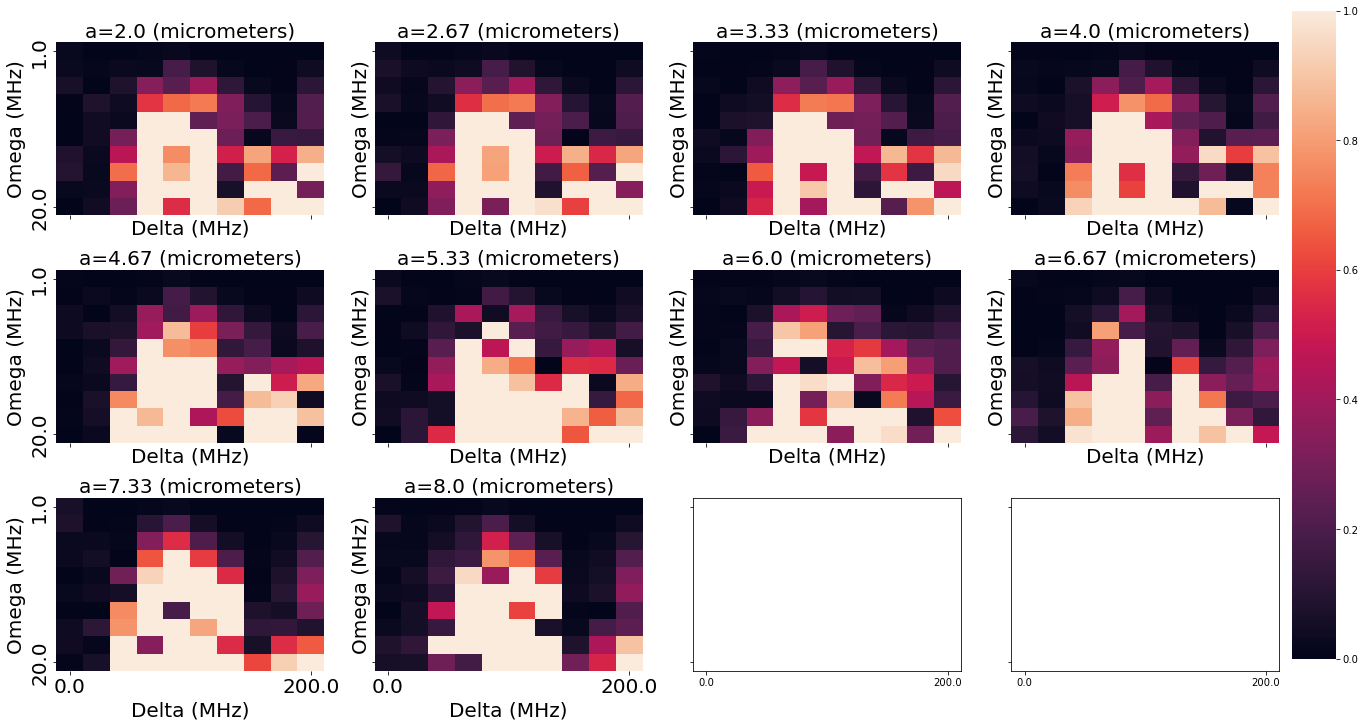

In [17]:
plt.rcParams["figure.figsize"] = (20,10)
visualize_diff(diff)

## Conclusion
Increasing `shots` does not help, and since the program is constant, increasing `steps` should not help either. Hence for the numpy solver, there is a fundamental error of around 1%, due to the fact that we only call the kernel once. In principle, we could increase the number of times of calling the kernel. 